In [195]:
# This version of the SVD fits using states expressed as excitations relative to a nuclear ground state
# RMS error for this fit looks to be a match with e35 produced by BAB
import random
import math
import scipy.linalg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from numpy.linalg import inv

# Read output-energy file as fixed-width file (fwf) into dataframe object, columns aren't labeled with a header
energyDF = pd.read_csv('xfit.dat', header=None, delim_whitespace=True).to_numpy()

# extract the SPEs and TBME's for the background (n50em) interaction
backgroundHam = energyDF[0,5:75]      # First 5 terms are not Hamiltonian parameters and can be dropped

# do the same for the fitted interaction from BAB
fittedHam = energyDF[1,5:75]

# extract experimental energies and experimental errors from dataframe
exp = energyDF[2:,1]
expAbs = energyDF[2:,2]
error = energyDF[2:,3]
#print(exp)

# extract matrix of beta coefficients for calculating absolute energies of each state
betasAbs = energyDF[2:,5:]

# extract a matrix of the beta coefficients in each energy contribution for the Hamiltonian in terms of excited states
betas = np.empty([len(exp),len(backgroundHam)])
for i in range(len(exp)):
    for j in range(len(backgroundHam)):
        if exp[i] <= 0:
            betas[i,j] = energyDF[i+2,j+5]
            gsContributions = betas[i,:]
        else:
            betas[i,j] = energyDF[i+2,j+5] - gsContributions[j]

In [325]:
# This segment does an SVD using the full set of available data
# Finally we construct our design matrix (G), initial parameter vector (pInit), and data vector (e) for fitting
e = np.empty(len(backgroundHam))
G = np.empty((len(backgroundHam),len(backgroundHam)))
for i in range(len(backgroundHam)):           # Contructing data vector (e)
    eTot = 0
    for k in range(len(exp)):
        eTot += (exp[k]*betas[k,i])/(error[k]**2)
    e[i] = eTot
for i in range(len(backgroundHam)):           # Constructing design matrix (G)
    for j in range(len(backgroundHam)):
        gTot = 0
        for k in range(len(exp)):
            gTot += (betas[k,i]*betas[k,j])/(error[k]**2)
        G[i,j] = gTot

# Here we perform an SVD of our design matrix and invert the singular values (in S)
# to create linear combinations of our parameters in p for our successive fits, iterating over the singular values
U, Svec, Ut = np.linalg.svd(G)
# Now we apply our minimization (e = Gp) by using our SVD matrices U,S, and Ut to rotate
# e and p into new vectors c and y, respectively
c = np.dot(Ut,e)
y = np.dot(Ut,backgroundHam)

# This is where we iteratively vary the linear combinations of parameters by selecting the increasing values in Sinv
# at the end we will apply fitted weights p to our initial parameters to calculate their RMS and energy RMS
eRMSfull = np.empty(len(Svec)+1)                  # The +1 is to include the unfitted case where we vary 0 linear combinations
pRMSfull = np.empty(len(Svec)+1)
fitEnergies = np.empty(len(exp))              # Array for storing fitted energies resulting from the chosen #VLC fit
numVLC = 35                                   # Number of VLC to choose for the output Hamiltonian
for i in range(len(backgroundHam)+1):
    yfit = np.zeros(len(backgroundHam))
    fitParameters = np.empty(len(backgroundHam))               # Array for storing fitted parameters in this iteration
    eResidual = np.empty(0)                             # Array for storing residuals for RMS calculation
    for j in range(len(backgroundHam)):
        if j < i:                             # Modify our linear combinations in y = U^Tp by our data in c = U^Te
            yfit[j] = c[j]/Svec[j]
        elif j >= i:                           # Keep the original linear combinations y = U^Tp from starting Hamiltonian
            yfit[j] = y[j]
    fitParameters = np.dot(U,yfit)                      # Rotate back to our fitted p vector through p = Uy
    for j in range(len(exp)):
        eFitTot = 0
        for k in range(len(backgroundHam)):
            eFitTot += fitParameters[k]*betas[j,k]                # Modify our initial energy contributions to state j by new weights
        if error[j] <= 1.0:
            eResidual = np.append(eResidual, exp[j]-eFitTot)
    if i == numVLC:
        outputHam = fitParameters
    pResidual = backgroundHam - fitParameters
    eRMSfull[i] = scipy.linalg.norm(eResidual)/math.sqrt(len(eResidual))
    pRMSfull[i] = scipy.linalg.norm(pResidual)/math.sqrt(len(pResidual))

35 vlc eRMS (average) = 0.1627935184710368  pRMS (average) =  0.2422014743583091
full SVD eRMS = 0.2914131501864506  pRMS = 1.194222241960273
BAB parameter RMS =  0.23512212244654504


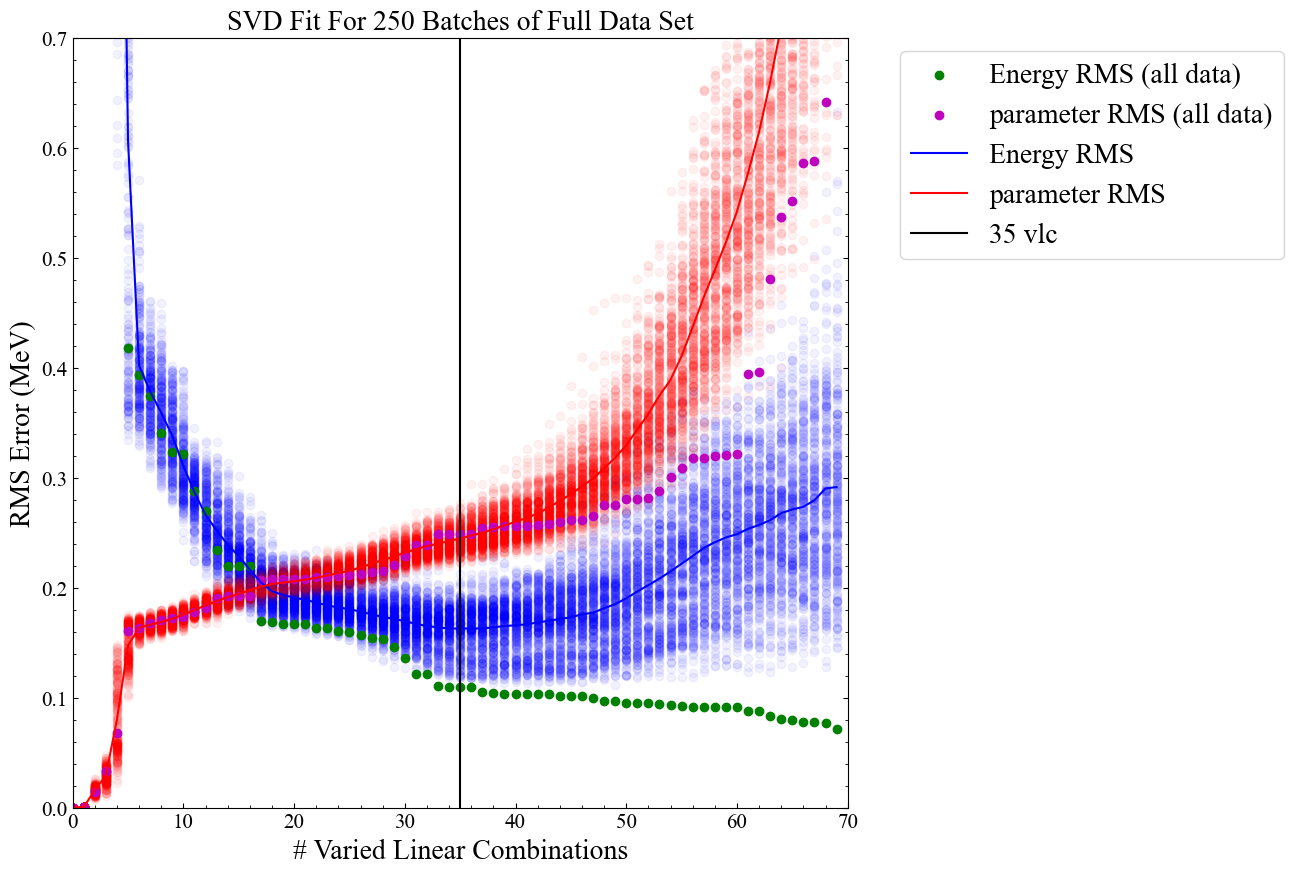

In [326]:
# This segment iterates (numBatches times) over randomized batches of the available data (including all ground states)
# All excited states from 79Cu to 99In are available for building training batches
# The full dataset is used for testing

numBatches = 250
eRMSRange = np.empty([numBatches,len(backgroundHam)+1])
pRMSRange = np.empty([numBatches, len(backgroundHam)+1])
for b in range(numBatches):
    # Select a random batch of data to fit the parameters to (making sure that ground states are always included in the batch)
    batchChoice = np.empty(len(exp))

    for i in range(len(exp)):
        if exp[i] <= 0.0:
            batchChoice[i] = 1
        else:
            k = random.randint(0,1)
            batchChoice[i] = k

    batchExp = np.empty(int(np.sum(batchChoice)))
    batchError = np.empty(len(batchExp))
    batchBetas = np.empty([len(batchExp), len(backgroundHam)])
    batchIndex = 0
    for i in range(len(exp)):
        if batchChoice[i] == 1:
            batchExp[batchIndex] = exp[i]
            batchError[batchIndex] = error[i]
            batchBetas[batchIndex] = betas[i]
            batchIndex += 1
                    
    # Finally we construct our design matrix (G), initial parameter vector (pInit), and data vector (e) for fitting
    e = np.empty(len(backgroundHam))
    G = np.empty((len(backgroundHam),len(backgroundHam)))
    for i in range(len(backgroundHam)):           # Contructing data vector (e)
        eTot = 0
        for k in range(len(batchExp)):
            eTot += (batchExp[k]*batchBetas[k,i])/(batchError[k]**2)
        e[i] = eTot
    for i in range(len(backgroundHam)):           # Constructing design matrix (G)
        for j in range(len(backgroundHam)):
            gTot = 0
            for k in range(len(batchExp)):
                gTot += (batchBetas[k,i]*batchBetas[k,j])/(batchError[k]**2)
            G[i,j] = gTot

    # Here we perform an SVD of our design matrix and invert the singular values (in S)
    # to create linear combinations of our parameters in p for our successive fits, iterating over the singular values
    U, Svec, Ut = np.linalg.svd(G)
    # Now we apply our minimization (e = Gp) by using our SVD matrices U,S, and Ut to rotate
    # e and p into new vectors c and y, respectively
    c = np.dot(Ut,e)
    y = np.dot(Ut,backgroundHam)

    # This is where we iteratively vary the linear combinations of parameters by selecting the increasing values in Sinv
    # at the end we will apply fitted weights p to our initial parameters to calculate their RMS and energy RMS
    eRMS = np.empty(len(Svec)+1)                  # The +1 is to include the unfitted case where we vary 0 linear combinations
    pRMS = np.empty(len(Svec)+1)
    fitEnergies = np.empty(len(exp))              # Array for storing fitted energies resulting from the chosen #VLC fit
    numVLC = 35                                   # Number of VLC to choose for the output Hamiltonian
    for i in range(len(backgroundHam)+1):
        yfit = np.empty(len(backgroundHam))
        fitParameters = np.empty(len(backgroundHam))               # Array for storing fitted parameters in this iteration
        eResidual = np.empty(0)                             # Array for storing residuals for RMS calculation
        for j in range(len(backgroundHam)):
            if j < i:                             # Modify our linear combinations in y = U^Tp by our data in c = U^Te
                yfit[j] = c[j]/Svec[j]
            elif j >= i:                           # Keep the original linear combinations y = U^Tp from starting Hamiltonian
                yfit[j] = y[j]
        fitParameters = np.dot(U,yfit)                      # Rotate back to our fitted p vector through p = Uy
        for j in range(len(exp)):
            eFitTot = 0
            for k in range(len(backgroundHam)):
                eFitTot += fitParameters[k]*betas[j,k]                # Modify our initial energy contributions to state j by new weights
            if error[j] <= 1.0:
                eResidual = np.append(eResidual, exp[j]-eFitTot)
        if i == numVLC:
            outputHam = fitParameters
        pResidual = backgroundHam - fitParameters
        eRMSRange[b,i] = scipy.linalg.norm(eResidual)/math.sqrt(len(eResidual))
        pRMSRange[b,i] = scipy.linalg.norm(pResidual)/math.sqrt(len(pResidual))
eRMSaverage = np.empty(len(eRMS))
pRMSaverage = np.empty(len(pRMS))
for i in range(len(eRMS)):
    eRMSaverage[i] = np.sum(eRMSRange[:,i])/numBatches
    pRMSaverage[i] = np.sum(pRMSRange[:,i])/numBatches

print('35 vlc eRMS (average) =', eRMSaverage[34], ' pRMS (average) = ', pRMSaverage[34])
print('full SVD eRMS =', eRMSaverage[69], ' pRMS =', pRMSaverage[69])
print('BAB parameter RMS = ', scipy.linalg.norm(backgroundHam-fittedHam)/math.sqrt(len(backgroundHam)))

x = [i for i in range(len(eRMS))] 
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
for i in range(numBatches):
	if i == 0:
		plt.scatter(x, eRMSRange[i], color='b', alpha=0.05)
		plt.scatter(x, pRMSRange[i], color='r', alpha=0.05) 
	plt.scatter(x, eRMSRange[i], color='b', alpha=0.05)
	plt.scatter(x, pRMSRange[i], color='r', alpha=0.05)
plt.scatter(x, eRMSfull, label='Energy RMS (all data)', color='g')
plt.scatter(x, pRMSfull, label='parameter RMS (all data)', color='m')
plt.plot(x, eRMSaverage, label='Energy RMS', color='b')
plt.plot(x, pRMSaverage, label='parameter RMS', color='r')
plt.axvline(x = 35, color = 'k', label = '35 vlc')
plt.xlabel('# Varied Linear Combinations')
plt.ylabel('RMS Error (MeV)')
plt.title('SVD Fit For %i Batches of Full Data Set' %numBatches, fontsize=20)
plt.axis([0,70,0.0,0.7])
plt.minorticks_on()
plt.tick_params(which="both", direction="in", right=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=20).set_alpha(1)
plt.show()

35 vlc eRMS (average) = 0.37098835163541993  pRMS (average) =  0.3834984382116278
full SVD eRMS = 12.632203290986025  pRMS = 12.493576830989525
BAB parameter RMS =  0.23512212244654504


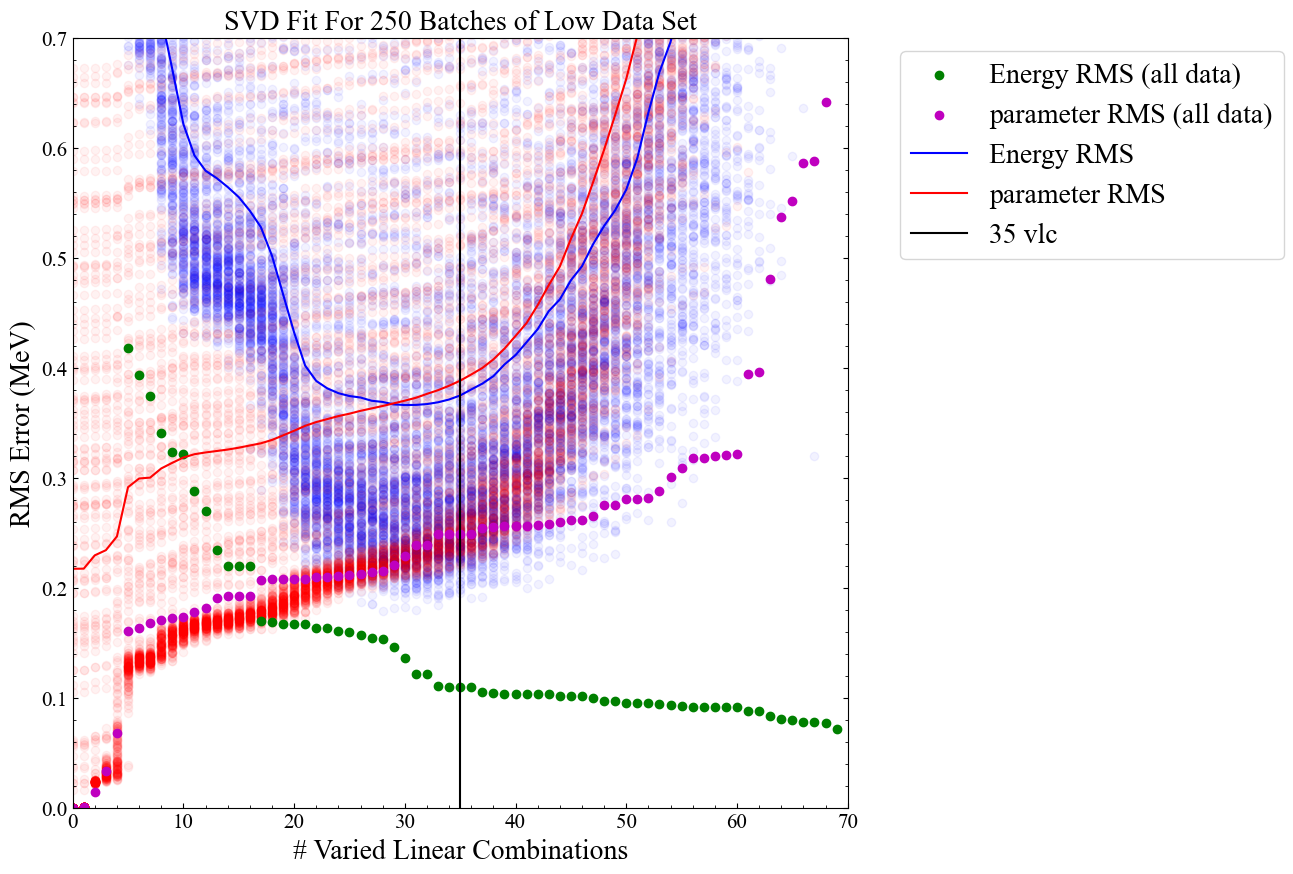

In [340]:
# This segment iterates (numBatches times) over randomized batches of the available data
# Only excited states from 79Cu through 89Y are available for building training batches
# The full dataset is used for testing

numBatches = 250
eRMSRangeLow = np.empty([numBatches,len(backgroundHam)+1])
pRMSRangeLow = np.empty([numBatches, len(backgroundHam)+1])
for b in range(numBatches):
    # Select a random batch of data to fit the parameters to (making sure that ground states are always included in the batch)
    batchChoice = np.empty(len(exp))

    for i in range(len(exp)):
        if exp[i] <= 0.0:
            batchChoice[i] = 1
        elif i < 104:
            k = random.randint(0,1)
            batchChoice[i] = k
        else:
            batchChoice[i] = 0

    batchExp = np.empty(int(np.sum(batchChoice)))
    batchError = np.empty(len(batchExp))
    batchBetas = np.empty([len(batchExp), len(backgroundHam)])
    batchIndex = 0
    for i in range(len(exp)):
        if batchChoice[i] == 1:
            batchExp[batchIndex] = exp[i]
            batchError[batchIndex] = error[i]
            batchBetas[batchIndex] = betas[i]
            batchIndex += 1
                    
    # Finally we construct our design matrix (G), initial parameter vector (pInit), and data vector (e) for fitting
    e = np.empty(len(backgroundHam))
    G = np.empty((len(backgroundHam),len(backgroundHam)))
    for i in range(len(backgroundHam)):           # Contructing data vector (e)
        eTot = 0
        for k in range(len(batchExp)):
            eTot += (batchExp[k]*batchBetas[k,i])/(batchError[k]**2)
        e[i] = eTot
    for i in range(len(backgroundHam)):           # Constructing design matrix (G)
        for j in range(len(backgroundHam)):
            gTot = 0
            for k in range(len(batchExp)):
                gTot += (batchBetas[k,i]*batchBetas[k,j])/(batchError[k]**2)
            G[i,j] = gTot

    # Here we perform an SVD of our design matrix and invert the singular values (in S)
    # to create linear combinations of our parameters in p for our successive fits, iterating over the singular values
    U, Svec, Ut = np.linalg.svd(G)
    # Now we apply our minimization (e = Gp) by using our SVD matrices U,S, and Ut to rotate
    # e and p into new vectors c and y, respectively
    c = np.dot(Ut,e)
    y = np.dot(Ut,backgroundHam)

    # This is where we iteratively vary the linear combinations of parameters by selecting the increasing values in Sinv
    # at the end we will apply fitted weights p to our initial parameters to calculate their RMS and energy RMS
    eRMS = np.empty(len(Svec)+1)                  # The +1 is to include the unfitted case where we vary 0 linear combinations
    pRMS = np.empty(len(Svec)+1)
    fitEnergies = np.empty(len(exp))              # Array for storing fitted energies resulting from the chosen #VLC fit
    numVLC = 35                                   # Number of VLC to choose for the output Hamiltonian
    for i in range(len(backgroundHam)+1):
        yfit = np.empty(len(backgroundHam))
        fitParameters = np.empty(len(backgroundHam))               # Array for storing fitted parameters in this iteration
        eResidual = np.empty(0)                             # Array for storing residuals for RMS calculation
        for j in range(len(backgroundHam)):
            if j < i:                             # Modify our linear combinations in y = U^Tp by our data in c = U^Te
                yfit[j] = c[j]/Svec[j]
            elif j >= i:                           # Keep the original linear combinations y = U^Tp from starting Hamiltonian
                yfit[j] = y[j]
        fitParameters = np.dot(U,yfit)                      # Rotate back to our fitted p vector through p = Uy
        for j in range(len(exp)):
            eFitTot = 0
            for k in range(len(backgroundHam)):
                eFitTot += fitParameters[k]*betas[j,k]                # Modify our initial energy contributions to state j by new weights
            if error[j] <= 1.0:
                eResidual = np.append(eResidual, exp[j]-eFitTot)
        if i == numVLC:
            outputHam = fitParameters
        pResidual = backgroundHam - fitParameters
        eRMSRangeLow[b,i] = scipy.linalg.norm(eResidual)/math.sqrt(len(eResidual))
        pRMSRangeLow[b,i] = scipy.linalg.norm(pResidual)/math.sqrt(len(pResidual))
eRMSaverageLow = np.empty(len(eRMS))
pRMSaverageLow = np.empty(len(pRMS))
for i in range(len(eRMS)):
    eRMSaverageLow[i] = np.sum(eRMSRangeLow[:,i])/numBatches
    pRMSaverageLow[i] = np.sum(pRMSRangeLow[:,i])/numBatches

print('35 vlc eRMS (average) =', eRMSaverageLow[34], ' pRMS (average) = ', pRMSaverageLow[34])
print('full SVD eRMS =', eRMSaverageLow[69], ' pRMS =', pRMSaverageLow[69])
print('BAB parameter RMS = ', scipy.linalg.norm(backgroundHam-fittedHam)/math.sqrt(len(backgroundHam)))

x = [i for i in range(len(eRMS))] 
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
for i in range(numBatches):
	if i == 0:
		plt.scatter(x, eRMSRangeLow[i], color='b', alpha=0.05)
		plt.scatter(x, pRMSRangeLow[i], color='r', alpha=0.05) 
	plt.scatter(x, eRMSRangeLow[i], color='b', alpha=0.05)
	plt.scatter(x, pRMSRangeLow[i], color='r', alpha=0.05)
plt.scatter(x, eRMSfull, label='Energy RMS (all data)', color='g')
plt.scatter(x, pRMSfull, label='parameter RMS (all data)', color='m')
plt.plot(x, eRMSaverageLow, label='Energy RMS', color='b')
plt.plot(x, pRMSaverageLow, label='parameter RMS', color='r')
plt.axvline(x = 35, color = 'k', label = '35 vlc')
plt.xlabel('# Varied Linear Combinations')
plt.ylabel('RMS Error (MeV)')
plt.title('SVD Fit For %i Batches of Low Data Set' %numBatches, fontsize=20)
plt.axis([0,70,0.0,0.7])
plt.minorticks_on()
plt.tick_params(which="both", direction="in", right=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=20).set_alpha(1)
plt.show()

35 vlc eRMS (average) = 0.45595241358298233  pRMS (average) =  0.3834984382116278
full SVD eRMS = 27.84363147555537  pRMS = 12.493576830989525
BAB parameter RMS =  0.23512212244654504


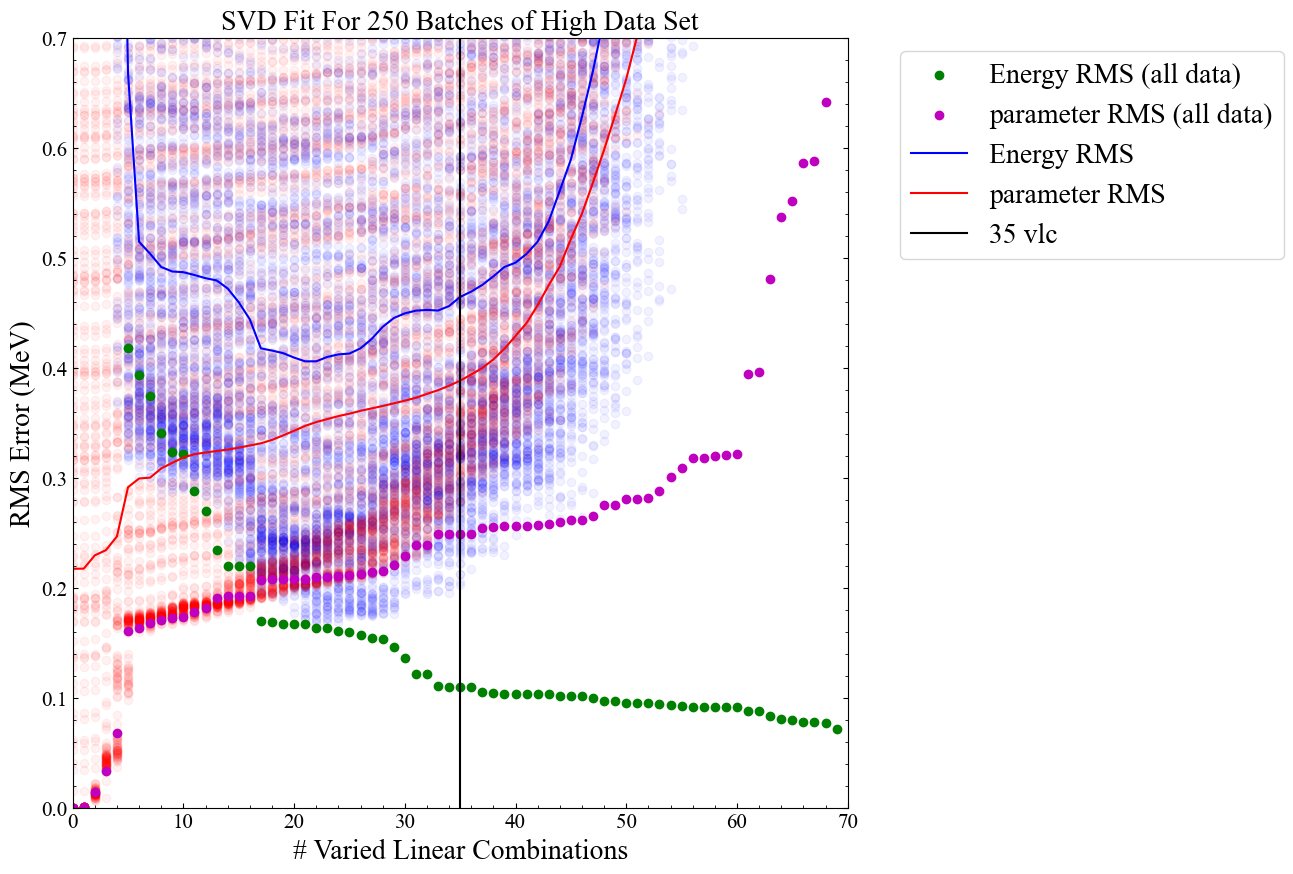

In [341]:
# This segment iterates (numBatches times) over randomized batches of the available data
# Only excited states from 79Cu through 89Y are available for building training batches
# The full dataset is used for testing

numBatches = 250
eRMSRangeHigh = np.empty([numBatches,len(backgroundHam)+1])
pRMSRangeHigh = np.empty([numBatches, len(backgroundHam)+1])
for b in range(numBatches):
    # Select a random batch of data to fit the parameters to (making sure that ground states are always included in the batch)
    batchChoice = np.empty(len(exp))

    for i in range(len(exp)):
        if exp[i] <= 0.0:
            batchChoice[i] = 1
        elif i >= 104:
            k = random.randint(0,1)
            batchChoice[i] = k
        else:
            batchChoice[i] = 0

    batchExp = np.empty(int(np.sum(batchChoice)))
    batchError = np.empty(len(batchExp))
    batchBetas = np.empty([len(batchExp), len(backgroundHam)])
    batchIndex = 0
    for i in range(len(exp)):
        if batchChoice[i] == 1:
            batchExp[batchIndex] = exp[i]
            batchError[batchIndex] = error[i]
            batchBetas[batchIndex] = betas[i]
            batchIndex += 1
                    
    # Finally we construct our design matrix (G), initial parameter vector (pInit), and data vector (e) for fitting
    e = np.empty(len(backgroundHam))
    G = np.empty((len(backgroundHam),len(backgroundHam)))
    for i in range(len(backgroundHam)):           # Contructing data vector (e)
        eTot = 0
        for k in range(len(batchExp)):
            eTot += (batchExp[k]*batchBetas[k,i])/(batchError[k]**2)
        e[i] = eTot
    for i in range(len(backgroundHam)):           # Constructing design matrix (G)
        for j in range(len(backgroundHam)):
            gTot = 0
            for k in range(len(batchExp)):
                gTot += (batchBetas[k,i]*batchBetas[k,j])/(batchError[k]**2)
            G[i,j] = gTot

    # Here we perform an SVD of our design matrix and invert the singular values (in S)
    # to create linear combinations of our parameters in p for our successive fits, iterating over the singular values
    U, Svec, Ut = np.linalg.svd(G)
    # Now we apply our minimization (e = Gp) by using our SVD matrices U,S, and Ut to rotate
    # e and p into new vectors c and y, respectively
    c = np.dot(Ut,e)
    y = np.dot(Ut,backgroundHam)

    # This is where we iteratively vary the linear combinations of parameters by selecting the increasing values in Sinv
    # at the end we will apply fitted weights p to our initial parameters to calculate their RMS and energy RMS
    eRMS = np.empty(len(Svec)+1)                  # The +1 is to include the unfitted case where we vary 0 linear combinations
    pRMS = np.empty(len(Svec)+1)
    fitEnergies = np.empty(len(exp))              # Array for storing fitted energies resulting from the chosen #VLC fit
    numVLC = 35                                   # Number of VLC to choose for the output Hamiltonian
    for i in range(len(backgroundHam)+1):
        yfit = np.empty(len(backgroundHam))
        fitParameters = np.empty(len(backgroundHam))               # Array for storing fitted parameters in this iteration
        eResidual = np.empty(0)                             # Array for storing residuals for RMS calculation
        for j in range(len(backgroundHam)):
            if j < i:                             # Modify our linear combinations in y = U^Tp by our data in c = U^Te
                yfit[j] = c[j]/Svec[j]
            elif j >= i:                           # Keep the original linear combinations y = U^Tp from starting Hamiltonian
                yfit[j] = y[j]
        fitParameters = np.dot(U,yfit)                      # Rotate back to our fitted p vector through p = Uy
        for j in range(len(exp)):
            eFitTot = 0
            for k in range(len(backgroundHam)):
                eFitTot += fitParameters[k]*betas[j,k]                # Modify our initial energy contributions to state j by new weights
            if error[j] <= 1.0:
                eResidual = np.append(eResidual, exp[j]-eFitTot)
        if i == numVLC:
            outputHam = fitParameters
        pResidual = backgroundHam - fitParameters
        eRMSRangeHigh[b,i] = scipy.linalg.norm(eResidual)/math.sqrt(len(eResidual))
        pRMSRangeHigh[b,i] = scipy.linalg.norm(pResidual)/math.sqrt(len(pResidual))
eRMSaverageHigh = np.empty(len(eRMS))
pRMSaverageHigh = np.empty(len(pRMS))
for i in range(len(eRMS)):
    eRMSaverageHigh[i] = np.sum(eRMSRangeHigh[:,i])/numBatches
    pRMSaverageHigh[i] = np.sum(pRMSRangeLow[:,i])/numBatches

print('35 vlc eRMS (average) =', eRMSaverageHigh[34], ' pRMS (average) = ', pRMSaverageHigh[34])
print('full SVD eRMS =', eRMSaverageHigh[69], ' pRMS =', pRMSaverageHigh[69])
print('BAB parameter RMS = ', scipy.linalg.norm(backgroundHam-fittedHam)/math.sqrt(len(backgroundHam)))

x = [i for i in range(len(eRMS))] 
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
for i in range(numBatches):
	if i == 0:
		plt.scatter(x, eRMSRangeHigh[i], color='b', alpha=0.05)
		plt.scatter(x, pRMSRangeHigh[i], color='r', alpha=0.05) 
	plt.scatter(x, eRMSRangeHigh[i], color='b', alpha=0.05)
	plt.scatter(x, pRMSRangeHigh[i], color='r', alpha=0.05)
plt.scatter(x, eRMSfull, label='Energy RMS (all data)', color='g')
plt.scatter(x, pRMSfull, label='parameter RMS (all data)', color='m')
plt.plot(x, eRMSaverageHigh, label='Energy RMS', color='b')
plt.plot(x, pRMSaverageHigh, label='parameter RMS', color='r')
plt.axvline(x = 35, color = 'k', label = '35 vlc')
plt.xlabel('# Varied Linear Combinations')
plt.ylabel('RMS Error (MeV)')
plt.title('SVD Fit For %i Batches of High Data Set' %numBatches, fontsize=20)
plt.axis([0,70,0.0,0.7])
plt.minorticks_on()
plt.tick_params(which="both", direction="in", right=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=20).set_alpha(1)
plt.show()

In [ ]:
'''
vlcCount = np.zeros([len(backgroundHam)+1])
print(vlcCount)
for i in range(len(backgroundHam)+1):
    vlcCount[i] = i
print(vlcCount)
rmsOutput = np.array([vlcCount, eRMS, pRMS])
with open("rms.dat", "w") as f:
    f.write("RMS Error \n")
    f.write("VLC    Energy     Params \n")
    np.savetxt(f, rmsOutput.T, delimiter=' ', fmt=('%-2d', '%10.4f', '%10.4f'))

outputs1 = np.array([exp, error, energyDF[2:,4], fitEnergies, energyDF[2:,4]-fitEnergies])
outputs2 = np.array([fittedHam, outputHam, outputHam-fittedHam])

with open("outputsBetas.dat","w") as f:
    f.write("Energy outputs   (0.096 MeV RMS for JP fit): \n")
    f.write("       exp      error        BAB         JP       Diff \n")
    np.savetxt(f, outputs1.T, delimiter=' ', fmt='%10.4f')
    f.write("Parameter outputs (0.235 MeV RMS for 35 VLC fit): \n")
    f.write("       BAB         JP       Diff \n")
    np.savetxt(f, outputs2.T, delimiter=' ', fmt='%10.4f')
'''